# Regression Discontinuity
This notebook illustrates the use of Regression Discontinuity in an empirical study. We analyze the effect of the antipoverty program *Progresa/Opportunidades* on the consumption behavior of families in Mexico in the early 2000s.

The program was intended for families in extreme poverty and included financial incentives for participation in measures that improved the family's health, nutrition and children's education. The effect of this program is a widely studied problem in social and economic sciences and, according to the WHO, was a very sucessful measure in terms of reducing extreme poverty om Mexico.

Eligibility for the program was determined based on a pre-intervention household poverty-index. Individuals above a certain threshold received the treatment (participation in the program) while individuals below the threshold were excluded and recorded as a control group. All observations above the threshold participated in the program, which makes the analysis fall into the standard (sharp) regression discontinuity design.

First, we need to install and load some packages.

In [1]:
!pip install rdd rdrobust
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import patsy
import math
from rdd.rdd import optimal_bandwidth, rdd, truncated_data
from rdrobust import rdrobust

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 8.1 MB/s eta 0:00:00
  Created wheel for rdd: filename=rdd-0.0.3-py3-none-any.whl size=4703 sha256=30ad62eac54cef0bfb3b917a75d0edb65a8e86fc0423ce80456ed197c394c093
  Stored in directory: /root/.cache/pip/wheels/53/bb/d2/0f022533528e6302bfd539ede3617bf64005b1a329540136b7
Successfully built rdd
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvic

We use a dataset assembled by [Calonico et al. (2014)](https://rdpackages.github.io/references/Calonico-Cattaneo-Titiunik_2014_ECMA--Supplemental.pdf) and follow the analysis in [Noack et al. (2023)](https://arxiv.org/pdf/2107.07942.pdf).

First, we open the data and remove any observations that have NaN values.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/progresa.csv", index_col=0)
df = df.dropna()
df.rename(columns={"index":"pov_index"}, inplace=True)
print("Shape of Data:")
print(df.shape)
print("Variable Names:")
print(df.columns)
df.head()

Shape of Data:
(1944, 27)
Variable Names:
Index(['hhpiso', 'hhrooms', 'hhwater', 'hhwaterin', 'hhbano', 'hhownhouse',
       'hhsize', 'hhelect', 'clus', 'headmale', 'headage', 'heademp',
       'wifeage', 'wifeeduc', 'headeduc', 'child_0to5', 'boy_0to5',
       'pov_index', 'conspcfood_t0', 'conspcfood_t1', 'conspcfood_t2',
       'conspcnonfood_t0', 'conspcnonfood_t1', 'conspcnonfood_t2', 'conspc_t0',
       'conspc_t1', 'conspc_t2'],
      dtype='object')


,hhpiso,hhrooms,hhwater,hhwaterin,hhbano,hhownhouse,hhsize,hhelect,clus,headmale,...,pov_index,conspcfood_t0,conspcfood_t1,conspcfood_t2,conspcnonfood_t0,conspcnonfood_t1,conspcnonfood_t2,conspc_t0,conspc_t1,conspc_t2
1,1.0,1.0,1.0,1.0,1.0,0.0,5,1,1,1,...,1.5410,260.223999,374.071991,379.208008,106.186668,183.149323,57.127998,366.410675,557.221313,436.335999
2,1.0,1.0,1.0,0.0,0.0,1.0,5,1,1,1,...,-0.6615,265.359985,574.375977,195.167999,87.266663,160.013336,112.136002,352.626648,734.389282,307.304016
3,1.0,1.0,0.0,0.0,1.0,1.0,4,1,1,1,...,-0.3240,604.549988,433.350006,367.010010,348.813324,263.083344,123.323334,953.363281,696.433350,490.333344
4,0.0,1.0,0.0,0.0,1.0,0.0,6,1,1,1,...,1.1500,233.259995,281.766663,260.468567,100.877777,140.233337,36.325714,334.137756,422.000000,296.794281
6,1.0,1.0,1.0,0.0,1.0,1.0,4,1,1,1,...,-0.8260,280.339996,185.110001,364.869995,158.416656,201.183334,68.000000,438.756653,386.293335,432.869995


The data set contains 1,944 observations for which full covariate information of 27 variables is available.

We want to measure the local average treatment effect of program participation on four outcome variables. The outcome variables are food and non-food consumption of the recorded families at two points in time, one year and two years after the implementation of the program.

The 85 baseline covariates, recorded prior to program implementation, include: the house-holds size, household head's age, sex, years of education and employment status, spouse's age and years of education, number of children not older than five years and their sex, house
characteristics: whether the house has cement floors, water connection, water connection inside the house, a bathroom, electricity, number of rooms, pre-intervention consumption, and an identifier of the urban locality in which the house is located.

The data fits to the pattern of a sharp RD design, namely, all individuals that were below the cut-off index received no intervention, and all individuals above the cut-off were eligible to join the *progresa* program and thus participated.

## Estimation without Covariates

First, we will perform a very simple RD estimation with a weighted linear regression. We use a triangular kernel, which assigns weights to observations based on their distance from the cutoff point. The weights decrease linearly as the distance from the cutoff point increases.

In [3]:
def triangular_kernel(index, h):
   weights = 1 - np.abs(index)/h
   weights[weights < 0] = 0
   return weights

The parameter `h` is the bandwidth that controls the range of observations that receive non-zero weights. We use the `IKbandwidth` function from the `rdd` package that implements the *Imbens-Kalyanaraman* method. Another standard approach would be to use the standard deviation of `index`.

In [4]:
h = optimal_bandwidth(X=df.pov_index, Y=df.conspcfood_t1, cut = 0)

We use the triangular kernel function to calculate weights for each observation. After that, we can fit two seperate linear regressions for both treatment and control groups.

In [5]:
weights = triangular_kernel(df.pov_index, h)
model_treated, model_control = LinearRegression(), LinearRegression()
model_treated.fit(y = df.loc[df.pov_index>0, "conspcfood_t1"].values.reshape(-1, 1),
                  X = df.loc[df.pov_index>0, "pov_index"].values.reshape(-1, 1),
                  sample_weight = weights[df.pov_index > 0])
model_control.fit(y = df.loc[df.pov_index<0, "conspcfood_t1"].values.reshape(-1, 1),
                  X = df.loc[df.pov_index<0, "pov_index"].values.reshape(-1, 1),
                  sample_weight = weights[df.pov_index < 0]);

The treatment effect at the cutoff point is estimated as the difference between the predictions of the two models at the cutoff point.

In [6]:
cutoff = 0
treatment_effect = model_treated.predict(np.array([cutoff]).reshape(-1, 1)) -\
                   model_control.predict(np.array([cutoff]).reshape(-1, 1))
treatment_effect[0,0]

-22.105321594809652

We estimate that the participation in the program reduced food consumption by $22.1$ units in the year following the intervention.The following plot visualizes the two weighted regressions at the cut-off for the last outcome variable (for food consumption in `t1`). We can clearly see the "jump" at the cut-off, which is our LATE.

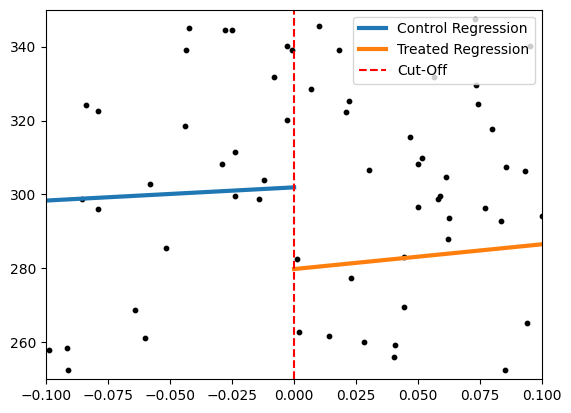

In [7]:
plt.scatter(df.pov_index, df.conspcfood_t1, s=10, color='black')  # s controls the size
neg_xval = np.linspace(-0.1,0,100)
neg_line = model_control.predict(neg_xval.reshape(-1,1))
pos_xval = np.linspace(0,0.1,100)
pos_line = model_treated.predict(pos_xval.reshape(-1,1))
plt.plot(neg_xval, neg_line, linewidth=3, label="Control Regression")
plt.plot(pos_xval, pos_line, linewidth=3, label="Treated Regression")
plt.axvline(x=0, color='red', linestyle='--', label="Cut-Off")
plt.legend()
plt.xlim(-0.1,0.1)
plt.ylim(250,350)
plt.show()

We can repeat the estimation using the `rdd` package, which yields us an estimate as well as a confidence band calculated according to the formulas presented in the book. We look at all four targets.

In [8]:
result = []
for outcome in ["conspcfood_t1", "conspcnonfood_t1", "conspcfood_t2", "conspcnonfood_t2"]:
  bandwidth = optimal_bandwidth(X=df.pov_index, Y=df[outcome], cut = 0)
  rdd_data = truncated_data(df, xname="pov_index", bandwidth=bandwidth, cut=0)
  rdd_weights = triangular_kernel(rdd_data.pov_index, bandwidth)
  rdd_result = rdd(rdd_data, "pov_index", yname=outcome, cut=0, verbose=False, weights=rdd_weights).fit()
  result.append([rdd_result.conf_int().values[1,0], rdd_result.params["TREATED"], rdd_result.conf_int().values[1,1]])
res_dataframe = pd.DataFrame(result, columns=["CI Lower", "LATE", "CI Upper"],
                             index = ["Food T_1", "Non-Food T_1", "Food T_2", "Non-Food T_2"])
res_dataframe

,CI Lower,LATE,CI Upper
Food T_1,-52.935619,-22.662303,7.611013
Non-Food T_1,-21.594042,0.725446,23.044935
Food T_2,16.799793,56.672823,96.545854
Non-Food T_2,10.692713,37.503480,64.314246


while the effects in the first year after the intervention are not significant on the $5\%$ level, we observe significant positive effects in the second year after an individual or household was accepted in the *Progresa* program. This is in accordance to the previous analysis of this dataset. One possible explanation for this is that through the program households have more money and can thus afford more. This was the desired effect of the program to combat hunger and extreme poverty.

## Estimation with Covariates

For the identification and estimation of the average treatment effect at the cutoff value no covariate information is required except the running variable, but nevertheless in many applications additional covariates are collected which might be exploited for the analysis to improve the efficiency of the estimates.

The standard approach is simply to take up the regressors in the weighted least squares regression.

In [9]:
np.average(df.loc[df.pov_index > 0,"hhownhouse"], weights = weights[df.pov_index > 0])

0.7415777131008151

In [10]:
model_treated, model_control = LinearRegression(), LinearRegression()
model_treated.fit(y = df.loc[df.pov_index>0, "conspcfood_t1"].values.reshape(-1, 1),
                  X = df.loc[df.pov_index>0, ["pov_index", "hhownhouse", "headage", "heademp", "headeduc"]],
                  sample_weight = weights[df.pov_index > 0])
model_control.fit(y = df.loc[df.pov_index<0, "conspcfood_t1"].values.reshape(-1, 1),
                  X = df.loc[df.pov_index<0, ["pov_index", "hhownhouse", "headage", "heademp", "headeduc"]],
                  sample_weight = weights[df.pov_index < 0]);
pred_t = model_treated.predict(pd.DataFrame({"pov_index" : cutoff,
                                             "hhownhouse" : np.average(df.loc[df.pov_index > 0,"hhownhouse"], weights = weights[df.pov_index > 0]),
                                             "headage" : np.average(df.loc[df.pov_index > 0,"headage"], weights = weights[df.pov_index > 0]),
                                             "heademp" : np.average(df.loc[df.pov_index > 0,"heademp"], weights = weights[df.pov_index > 0]),
                                             "headeduc" : np.average(df.loc[df.pov_index > 0,"headeduc"], weights = weights[df.pov_index > 0])},
                                            index=[0]))
pred_c = model_control.predict(pd.DataFrame({"pov_index" : cutoff,
                                             "hhownhouse" : np.average(df.loc[df.pov_index < 0,"hhownhouse"], weights = weights[df.pov_index < 0]),
                                             "headage" : np.average(df.loc[df.pov_index < 0,"headage"], weights = weights[df.pov_index < 0]),
                                             "heademp" : np.average(df.loc[df.pov_index < 0,"heademp"], weights = weights[df.pov_index < 0]),
                                             "headeduc" : np.average(df.loc[df.pov_index < 0,"headeduc"], weights = weights[df.pov_index < 0])},
                                            index=[0]))
treatment_effect = pred_t - pred_c
treatment_effect[0][0]

-23.78101031569355

Including these selected covariates does not have a significant impact on the LATE estimation. Again, we can also use `rdd` to repeat the estimation with all other outcomes.


In [11]:
result = []
for outcome in ["conspcfood_t1", "conspcnonfood_t1", "conspcfood_t2", "conspcnonfood_t2"]:
  bandwidth = optimal_bandwidth(X=df.pov_index, Y=df[outcome], cut = 0)
  rdd_data = truncated_data(df, xname="pov_index", bandwidth=bandwidth, cut=0)
  rdd_weights = triangular_kernel(rdd_data.pov_index, bandwidth)
  rdd_result = rdd(rdd_data, "pov_index", yname=outcome,
                   cut=0, verbose=False, weights=rdd_weights,
                   controls=["hhownhouse", "headage", "heademp", "headeduc"]).fit(cov_type='hc1')
  result.append([rdd_result.conf_int().values[1,0], rdd_result.params["TREATED"], rdd_result.conf_int().values[1,1]])
res_dataframe = pd.DataFrame(result, columns=["CI Lower", "LATE", "CI Upper"],
                             index = ["Food T_1", "Non-Food T_1", "Food T_2", "Non-Food T_2"])
res_dataframe

,CI Lower,LATE,CI Upper
Food T_1,-57.073423,-23.745660,9.582102
Non-Food T_1,-24.314050,0.642404,25.598858
Food T_2,-3.680765,56.926571,117.533907
Non-Food T_2,-0.061389,38.889796,77.840981


Overall, the adjustment by only a few covariates has not changed the results much from the result without covariates.

## Estimation using ML

As discussed in the book, including many covariables in the RD estimation can be benefitial for multiple reasons:
1. **Efficiency and power improvements**: Similar as in randomized control trials, using covariates can increase efficiency and improve power.
2. **Auxiliary information**: In RDD the score determins the treatment assignment and measurement errors in the running variable can distort the results. Additional covariates can be exploited to overcome these issues or to deal with missing data problems.
3. **Treatment effect heterogeneity**: Covariates can be used to define subgroups in which the treatment effects differ.
4. **Other parameters of interest and extrapolation**: As the identified treatment effect in RDD is local at the cutoff, additional covariates might help for extrapolation of the treatment effects or identify other causal parameters.

However, including a high number of covariates also comes with additional challenges, such as variables selection, non-linearities or interactions between covariates. The best way to overcome these is the use of modern ML methods.

There are multiple ways to implement the estimators presented in the book, we will closely follow the analysis of [Noack et al. (2023)](https://arxiv.org/pdf/2107.07942.pdf). We set up running variable and outcome as above. The baseline covariates will be all the other variables in the given dataset.

In [12]:
# Running Variable and Outcome
investigated_outcome = "conspcfood_t1"
df.rename(columns={"pov_index": "X", investigated_outcome: "Y"}, inplace=True)

# Baseline covariates including consumption
b_covs = df.columns[[0,1,2,3,4,5,6,7,10,11,12,13,14,15,16,18,21]]

# Fixed effects for localities
i_fe = pd.get_dummies(df['clus'], drop_first=True)

# Flexible covariates including localities indicators
f_covs = patsy.dmatrix('~ (' + ' + '.join(b_covs) + ')**2', data=df, return_type='dataframe')

# Dropping the intercept column that is automatically added by patsy
f_covs = f_covs.iloc[:, 1:]

Z_lasso = pd.concat([i_fe, f_covs], axis=1)

We will use the package `RDHonest` for the RD estimation. Before starting the DML procedure, we have to estimate a bandwidth to restrict the samples in the first stage estimation.

In [13]:
h_fs = rdrobust(y = df.Y, x=df.X).bws.values[1,0]

Mass points detected in the running variable.
Mass points detected in the running variable.


The next chunk sets up the crossfitting and estimates the function $\eta(Z)$, which we will use to adjust $Y$ for the second stage. We use Random Forest, a Boosting implementation, Linear Regression and Lasso with both a baseline and flexible covariate structure.

In [27]:
# Set up the cross-fitting
n = df.shape[0]
Kf = 5 # Number of folds
sampleframe = np.repeat(range(0, Kf), math.ceil(n/Kf))
cfgroup = np.random.choice(sampleframe, size=n, replace=False)

# Matrix to store eta predictions
eta_fit = np.empty((n, 5))

# Create vector of observations to be considered in the first stage model
weights = np.abs(df.X)<h_fs

for k in range(Kf):
  print("Estimating fold ", k)
  fold = (cfgroup == k)

  data_treated = df.loc[(df.X>0) & ~fold & (weights>0),]
  data_control = df.loc[(df.X<0) & ~fold & (weights>0),]

  data_fold = df.loc[fold,]

  rf1 = RandomForestRegressor(max_features = 4, n_estimators = 1000)
  rf1.fit(y=data_treated.Y, X=data_treated[b_covs])
  rf0 = RandomForestRegressor(max_features = 4, n_estimators = 1000)
  rf0.fit(y=data_control.Y, X=data_control[b_covs])
  eta_fit[fold,0] = (rf1.predict(data_fold[b_covs]) + rf0.predict(data_fold[b_covs]))/2

  lgbm1 = LGBMRegressor(verbosity=-1)
  lgbm1.fit(y=data_treated.Y, X=data_treated[b_covs])
  lgbm0 = LGBMRegressor(verbosity=-1)
  lgbm0.fit(y=data_control.Y, X=data_control[b_covs])
  eta_fit[fold,1] = (lgbm1.predict(data_fold[b_covs]) + lgbm0.predict(data_fold[b_covs]))/2

  lm1 = LinearRegression()
  lm1.fit(y=data_treated.Y, X=data_treated[b_covs])
  lm0 = LinearRegression()
  lm0.fit(y=data_control.Y, X=data_control[b_covs])
  eta_fit[fold,2] = (lm1.predict(data_fold[b_covs]) + lm0.predict(data_fold[b_covs]))/2

  las_base1 = LassoCV()
  las_base1.fit(y=data_treated.Y, X=data_treated[b_covs])
  las_base0 = LassoCV()
  las_base0.fit(y=data_control.Y, X=data_control[b_covs])
  eta_fit[fold,3] = (las_base1.predict(data_fold[b_covs]) + las_base0.predict(data_fold[b_covs]))/2

  X_flex_treated = pd.concat([Z_lasso.loc[data_treated.index],data_treated[b_covs]], axis=1)
  X_flex_control = pd.concat([Z_lasso.loc[data_control.index],data_control[b_covs]], axis=1)
  X_flex_fold = pd.concat([Z_lasso.loc[data_fold.index],data_fold[b_covs]], axis=1)
  X_flex_treated.columns = X_flex_treated.columns.astype(str)
  X_flex_control.columns = X_flex_control.columns.astype(str)
  X_flex_fold.columns = X_flex_fold.columns.astype(str)
  las_flex1 = LassoCV()
  las_flex1.fit(y=data_treated.Y, X=X_flex_treated)
  las_flex0 = LassoCV()
  las_flex0.fit(y=data_control.Y, X=X_flex_control)
  eta_fit[fold,4] = (las_flex1.predict(X_flex_fold) + \
                     las_flex0.predict(X_flex_fold)) / 2

Estimating fold  0
Estimating fold  1
Estimating fold  2
Estimating fold  3
Estimating fold  4


With the estimated $\hat{\eta}(Z)$ we can correct for confounding in $Y$ and now run the RD estimation as second stage again.

In [28]:
adj_results = []
methods = ["Random Forest", "Gradient Boosting", "Linear Regression",
           "Lasso Baseline", "Lasso Flexible"]

for i in range(len(methods)):
  M_Y = df.Y - eta_fit[:,i]
  rd_call = rdrobust(y=M_Y, x=df.X)
  adj_results.append([rd_call.ci.loc["Robust"].values[0],
                      rd_call.coef.loc["Robust"].values[0],
                      rd_call.ci.loc["Robust"].values[1]])
adj_frame = pd.DataFrame(adj_results, columns=["CI Lower", "LATE", "CI Upper"],
                         index=methods)
adj_frame

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


,CI Lower,LATE,CI Upper
Random Forest,-61.247096,-22.525431,16.196233
Gradient Boosting,-62.917212,-20.552778,21.811656
Linear Regression,-62.365263,-24.135701,14.093861
Lasso Baseline,-59.103806,-20.818984,17.465838
Lasso Flexible,-60.012069,-20.926892,18.158285
